In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from params import BASE_DIR, PROFILES, RERUNS, MODELS_TITLE
BASE_DIR, PROFILES, RERUNS, MODELS_TITLE

('../../experiments/misspec-sin10/',
 ['sin10-3x256-s03',
  'sin10-3x256-sl',
  'sin10-2x128-s03',
  'sin10-2x128-sl',
  'sin10-1x64-s03',
  'sin10-1x64-sl',
  'sin10-linear-s03',
  'sin10-linear-sl'],
 10,
 'Sin10')

In [4]:
# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

# make tables dir
if not os.path.exists(BASE_DIR + "tables"):
    os.makedirs(BASE_DIR + "tables")

In [5]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

names = [configs[p]["NAME"] for p in PROFILES]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(PROFILES))]

In [6]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x10594fd00>)

In [7]:
#Load train and eval stats

train_stats = {}
for p in PROFILES:
    name = configs[p]["NAME"]
    train_stats[name] = []
    for run in range(1, RERUNS+1):
        with open(f"{BASE_DIR}/results/{name}/train_stats_{run}.json", "r") as f:
            train_stats[name].append(json.load(f))

results = {}
for p in PROFILES:
    name = configs[p]["NAME"]
    results[name] = []
    for run in range(1, RERUNS+1):
        with open(f"{BASE_DIR}/results/{name}/results_{run}.json", "r") as f:
            results[name].append(json.load(f))

# Load posterior samples
posterior_samples = {}
for p in PROFILES:
    name = configs[p]["NAME"]
    posterior_samples[name] = []
    # Load posterior samples
    for run in range(1, RERUNS+1):
        train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_{run}.npy")
        test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_{run}.npy")
        test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_{run}.npy")
        test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_{run}.npy")

        posterior_samples[name].append({
            "train": train,
            "test": test,
            "test_in_domain": test_in_domain,
            "test_out_domain": test_out_domain
        })


# Uncertainties
predictive_uncertainties = {}
for p in PROFILES:
    name = configs[p]["NAME"]
    predictive_uncertainties[name] = []
    # Load posterior samples
    for run in range(1, RERUNS+1):
        with open(f"{BASE_DIR}/results/{name}/predictive_uncertainties_{run}.json", "r") as f:
            predictive_uncertainties[name].append(json.load(f))


# Weight uncertainty
weight_uncertainties = {}
for p in PROFILES:
    name = configs[p]["NAME"]
    weight_uncertainties[name] = []
    # Load posterior samples
    for run in range(1, RERUNS+1):
        with open(f"{BASE_DIR}/results/{name}/weight_data_{run}.json", "r") as f:
            weight_uncertainties[name].append(json.load(f))

In [8]:
if False:
    for p in PROFILES:
        name = configs[p]["NAME"]
        # Load posterior samples
        for run in range(1, RERUNS+1):
            with open(f"{BASE_DIR}/results/{name}/weight_data_{run}.json", "r") as f:
                wu = json.load(f)
            print(wu["mean_weight_scale"])

            weight_scale_list = []
            for n, data in wu["sites"].items():
                if "scale" in n and "likelihood" not in n:
                    weight_scale_list.extend(data)
            wu["mean_weight_scale"] = np.mean(weight_scale_list)
            wu["min_weight_scale"] = np.min(weight_scale_list)
            wu["max_weight_scale"] = np.max(weight_scale_list)
            print(wu["mean_weight_scale"])

            with open(f"{BASE_DIR}/results/{name}/weight_data_{run}.json", "w") as f:
                json.dump(wu, f, indent=4)

In [9]:
#Generate table for Train
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["train"]["error"]["rmse"] for i in range(RERUNS)])
    rmse_std = np.std([results[name][i]["train"]["error"]["rmse"] for i in range(RERUNS)])
    mae_mean = np.mean([results[name][i]["train"]["error"]["mae"] for i in range(RERUNS)])
    mae_std = np.std([results[name][i]["train"]["error"]["mae"] for i in range(RERUNS)])
    ll_mean = np.mean([results[name][i]["train"]["error"]["loglikelihood"] for i in range(RERUNS)])
    ll_std = np.std([results[name][i]["train"]["error"]["loglikelihood"] for i in range(RERUNS)])
    lik_std_mean = [weight_uncertainties[name][i]["likelihood_scale"]["mean"] for i in range(RERUNS)]
    lik_std_std = [weight_uncertainties[name][i]["likelihood_scale"]["std"] for i in range(RERUNS)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

train_table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    train_table["Name"] = temp_t["name"]
    train_table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str)) #!!!!!!
    train_table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    train_table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    train_table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

train_table = train_table.set_index("Name")
train_table.to_csv(f"{BASE_DIR}/tables/train.csv")

print("TRAIN")
display(train_table)
print()

# Generate table for in_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["in_domain"]["error"]["rmse"] for i in range(RERUNS)])
    rmse_std = np.std([results[name][i]["in_domain"]["error"]["rmse"] for i in range(RERUNS)])
    mae_mean = np.mean([results[name][i]["in_domain"]["error"]["mae"] for i in range(RERUNS)])
    mae_std = np.std([results[name][i]["in_domain"]["error"]["mae"] for i in range(RERUNS)])
    ll_mean = np.mean([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(RERUNS)])
    ll_std = np.std([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(RERUNS)])
    lik_std_mean = [weight_uncertainties[name][i]["likelihood_scale"]["mean"] for i in range(RERUNS)]
    lik_std_std = [weight_uncertainties[name][i]["likelihood_scale"]["std"] for i in range(RERUNS)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

in_domain_table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    in_domain_table["Name"] = temp_t["name"]
    in_domain_table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    in_domain_table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    in_domain_table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    in_domain_table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

in_domain_table = in_domain_table.set_index("Name")
in_domain_table.to_csv(f"{BASE_DIR}/tables/in_domain.csv")

print("IN DOMAIN")
display(in_domain_table)
print()


# Generate table for out_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["out_domain"]["error"]["rmse"] for i in range(RERUNS)])
    rmse_std = np.std([results[name][i]["out_domain"]["error"]["rmse"] for i in range(RERUNS)])
    mae_mean = np.mean([results[name][i]["out_domain"]["error"]["mae"] for i in range(RERUNS)])
    mae_std = np.std([results[name][i]["out_domain"]["error"]["mae"] for i in range(RERUNS)])
    ll_mean = np.mean([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(RERUNS)])
    ll_std = np.std([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(RERUNS)])
    lik_std_mean = [weight_uncertainties[name][i]["likelihood_scale"]["mean"] for i in range(RERUNS)]
    lik_std_std = [weight_uncertainties[name][i]["likelihood_scale"]["std"] for i in range(RERUNS)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

out_domain_table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    out_domain_table["Name"] = temp_t["name"]
    out_domain_table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    out_domain_table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    out_domain_table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    out_domain_table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

out_domain_table = out_domain_table.set_index("Name")
out_domain_table.to_csv(f"{BASE_DIR}/tables/out_domain.csv")

print("OUT DOMAIN")
display(out_domain_table)
print()


TRAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s03,0.3±0.0,0.53±0.03,0.41±0.02,-1.25±0.19
sin10-3x256-sl,0.75±0.15,0.75±0.18,0.57±0.13,-1.12±0.24
sin10-2x128-s03,0.3±0.0,0.62±0.08,0.49±0.07,-1.87±0.6
sin10-2x128-sl,0.66±0.07,0.66±0.06,0.52±0.04,-1.01±0.09
sin10-1x64-s03,0.3±0.0,2.46±0.12,1.87±0.07,-33.47±3.19
sin10-1x64-sl,2.79±0.2,2.79±0.07,2.12±0.05,-2.45±0.02
sin10-linear-s03,0.3±0.0,6.68±0.01,5.41±0.01,-247.63±0.44
sin10-linear-sl,6.66±0.42,6.69±0.01,5.42±0.01,-3.32±0.0



IN DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s03,0.3±0.0,0.69±0.06,0.53±0.05,-2.38±0.48
sin10-3x256-sl,0.75±0.15,0.78±0.14,0.6±0.11,-1.18±0.18
sin10-2x128-s03,0.3±0.0,1.3±0.6,0.99±0.45,-9.56±9.26
sin10-2x128-sl,0.66±0.07,0.72±0.07,0.56±0.06,-1.09±0.1
sin10-1x64-s03,0.3±0.0,2.8±0.11,2.1±0.07,-43.23±3.48
sin10-1x64-sl,2.79±0.2,3.02±0.1,2.27±0.08,-2.53±0.04
sin10-linear-s03,0.3±0.0,6.69±0.01,5.46±0.01,-248.37±0.51
sin10-linear-sl,6.66±0.42,6.7±0.01,5.47±0.01,-3.32±0.0



OUT DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s03,0.3±0.0,35.32±3.85,28.96±3.22,-6951.66±1490.18
sin10-3x256-sl,0.75±0.15,35.3±6.21,28.81±4.97,-1186.71±755.36
sin10-2x128-s03,0.3±0.0,25.56±8.82,20.62±7.23,-3736.65±2482.0
sin10-2x128-sl,0.66±0.07,38.85±3.62,31.57±3.08,-1727.81±593.12
sin10-1x64-s03,0.3±0.0,21.03±1.11,17.3±0.93,-2458.79±254.34
sin10-1x64-sl,2.79±0.2,21.54±0.97,17.68±0.81,-32.01±2.8
sin10-linear-s03,0.3±0.0,18.94±0.01,15.39±0.01,-1993.93±2.8
sin10-linear-sl,6.66±0.42,18.88±0.11,15.34±0.09,-6.88±0.22


In [10]:
# Generate tables for uncertainty
# Weight uncertainty

temp_t = pd.DataFrame(columns=["name", "mean_w_scale", "mean_w_scale_std", "min_w_scale", "min_w_scale_std", "max_w_scale", "max_w_scale_std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    mean_w_scale = np.mean([weight_uncertainties[name][i]["mean_weight_scale"] for i in range(RERUNS)])
    mean_w_scale_std = np.std([weight_uncertainties[name][i]["mean_weight_scale"] for i in range(RERUNS)])
    min_w_scale = np.mean([weight_uncertainties[name][i]["min_weight_scale"] for i in range(RERUNS)])
    min_w_scale_std = np.std([weight_uncertainties[name][i]["min_weight_scale"] for i in range(RERUNS)])
    max_w_scale = np.mean([weight_uncertainties[name][i]["max_weight_scale"] for i in range(RERUNS)])
    max_w_scale_std = np.std([weight_uncertainties[name][i]["max_weight_scale"] for i in range(RERUNS)])

    temp_t = temp_t._append({
        "name": name,
        "mean_w_scale": mean_w_scale,
        "mean_w_scale_std": mean_w_scale_std,
        "min_w_scale": min_w_scale,
        "min_w_scale_std": min_w_scale_std,
        "max_w_scale": max_w_scale,
        "max_w_scale_std": max_w_scale_std,
    }, ignore_index=True)

weight_table = pd.DataFrame(columns=["Name", "likelihood_sigma", "mean_w_scale", "min_w_scale", "max_w_scale"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    weight_table["Name"] = temp_t["name"]
    weight_table["likelihood_sigma"] = train_table["Likelihood_std"].values
    weight_table["mean_w_scale"] = temp_t["mean_w_scale"].round(round).astype(str).add('±').add(temp_t["mean_w_scale_std"].multiply(2).round(round).astype(str))
    weight_table["min_w_scale"] = temp_t["min_w_scale"].round(round).astype(str).add('±').add(temp_t["min_w_scale_std"].multiply(2).round(round).astype(str))
    weight_table["max_w_scale"] = temp_t["max_w_scale"].round(round).astype(str).add('±').add(temp_t["max_w_scale_std"].multiply(2).round(round).astype(str))

weight_table = weight_table.set_index("Name")
weight_table.to_csv(f"{BASE_DIR}/tables/weight_uncertainty.csv")

print("WEIGHT UNCERTAINTY")
display(weight_table)
print()


# Predictive uncertainty

# Train
temp_t = pd.DataFrame(columns=["name", "mean_p_scale", "mean_p_scale_std", "min_p_scale", "min_p_scale_std", "max_p_scale", "max_p_scale_std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    mean_p_scale = np.mean([predictive_uncertainties[name][i]["train"]["mean_predictive_scale"] for i in range(RERUNS)])
    mean_p_scale_std = np.std([predictive_uncertainties[name][i]["train"]["mean_predictive_scale"] for i in range(RERUNS)])
    min_p_scale = np.mean([predictive_uncertainties[name][i]["train"]["min_predictive_scale"] for i in range(RERUNS)])
    min_p_scale_std = np.std([predictive_uncertainties[name][i]["train"]["min_predictive_scale"] for i in range(RERUNS)])
    max_p_scale = np.mean([predictive_uncertainties[name][i]["train"]["max_predictive_scale"] for i in range(RERUNS)])
    max_p_scale_std = np.std([predictive_uncertainties[name][i]["train"]["max_predictive_scale"] for i in range(RERUNS)])

    temp_t = temp_t._append({
        "name": name,
        "mean_p_scale": mean_p_scale,
        "mean_p_scale_std": mean_p_scale_std,
        "min_p_scale": min_p_scale,
        "min_p_scale_std": min_p_scale_std,
        "max_p_scale": max_p_scale,
        "max_p_scale_std": max_p_scale_std
    }, ignore_index=True)

pred_table = pd.DataFrame(columns=["Name", "likelihood_sigma", "mean_p_scale", "min_p_scale", "max_p_scale"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]

    pred_table["Name"] = temp_t["name"]
    pred_table["likelihood_sigma"] = train_table["Likelihood_std"].values
    pred_table["mean_p_scale"] = temp_t["mean_p_scale"].round(round).astype(str).add('±').add(temp_t["mean_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["min_p_scale"] = temp_t["min_p_scale"].round(round).astype(str).add('±').add(temp_t["min_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["max_p_scale"] = temp_t["max_p_scale"].round(round).astype(str).add('±').add(temp_t["max_p_scale_std"].multiply(2).round(round).astype(str))

pred_table = pred_table.set_index("Name")
pred_table.to_csv(f"{BASE_DIR}/tables/pred_uncertainty_train.csv")

print("TRAIN")
display(pred_table)
print()

# In domain
temp_t = pd.DataFrame(columns=["name", "mean_p_scale", "mean_p_scale_std", "min_p_scale", "min_p_scale_std", "max_p_scale", "max_p_scale_std"])

for p in PROFILES:
    name = configs[p]["NAME"]
    mean_p_scale = np.mean([predictive_uncertainties[name][i]["in_domain"]["mean_predictive_scale"] for i in range(RERUNS)])
    mean_p_scale_std = np.std([predictive_uncertainties[name][i]["in_domain"]["mean_predictive_scale"] for i in range(RERUNS)])
    min_p_scale = np.mean([predictive_uncertainties[name][i]["in_domain"]["min_predictive_scale"] for i in range(RERUNS)])
    min_p_scale_std = np.std([predictive_uncertainties[name][i]["in_domain"]["min_predictive_scale"] for i in range(RERUNS)])
    max_p_scale = np.mean([predictive_uncertainties[name][i]["in_domain"]["max_predictive_scale"] for i in range(RERUNS)])
    max_p_scale_std = np.std([predictive_uncertainties[name][i]["in_domain"]["max_predictive_scale"] for i in range(RERUNS)])

    temp_t = temp_t._append({
        "name": name,
        "mean_p_scale": mean_p_scale,
        "mean_p_scale_std": mean_p_scale_std,
        "min_p_scale": min_p_scale,
        "min_p_scale_std": min_p_scale_std,
        "max_p_scale": max_p_scale,
        "max_p_scale_std": max_p_scale_std
    }, ignore_index=True)

pred_table = pd.DataFrame(columns=["Name", "likelihood_sigma", "mean_p_scale", "min_p_scale", "max_p_scale"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    pred_table["Name"] = temp_t["name"]
    pred_table["likelihood_sigma"] = train_table["Likelihood_std"].values
    pred_table["mean_p_scale"] = temp_t["mean_p_scale"].round(round).astype(str).add('±').add(temp_t["mean_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["min_p_scale"] = temp_t["min_p_scale"].round(round).astype(str).add('±').add(temp_t["min_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["max_p_scale"] = temp_t["max_p_scale"].round(round).astype(str).add('±').add(temp_t["max_p_scale_std"].multiply(2).round(round).astype(str))

pred_table = pred_table.set_index("Name")
pred_table.to_csv(f"{BASE_DIR}/tables/pred_uncertainty_in_domain.csv")

print("IN DOMAIN")
display(pred_table)
print()


# Out domain
temp_t = pd.DataFrame(columns=["name", "mean_p_scale", "mean_p_scale_std", "min_p_scale", "min_p_scale_std", "max_p_scale", "max_p_scale_std"])

for p in PROFILES:
    name = configs[p]["NAME"]

    mean_p_scale = np.mean([predictive_uncertainties[name][i]["out_domain"]["mean_predictive_scale"] for i in range(RERUNS)])
    mean_p_scale_std = np.std([predictive_uncertainties[name][i]["out_domain"]["mean_predictive_scale"] for i in range(RERUNS)])
    min_p_scale = np.mean([predictive_uncertainties[name][i]["out_domain"]["min_predictive_scale"] for i in range(RERUNS)])
    min_p_scale_std = np.std([predictive_uncertainties[name][i]["out_domain"]["min_predictive_scale"] for i in range(RERUNS)])
    max_p_scale = np.mean([predictive_uncertainties[name][i]["out_domain"]["max_predictive_scale"] for i in range(RERUNS)])
    max_p_scale_std = np.std([predictive_uncertainties[name][i]["out_domain"]["max_predictive_scale"] for i in range(RERUNS)])

    temp_t = temp_t._append({
        "name": name,
        "mean_p_scale": mean_p_scale,
        "mean_p_scale_std": mean_p_scale_std,
        "min_p_scale": min_p_scale,
        "min_p_scale_std": min_p_scale_std,
        "max_p_scale": max_p_scale,
        "max_p_scale_std": max_p_scale_std
    }, ignore_index=True)

pred_table = pd.DataFrame(columns=["Name", "likelihood_sigma", "mean_p_scale", "min_p_scale", "max_p_scale"])

round = 2
for p in PROFILES:
    name = configs[p]["NAME"]
    pred_table["Name"] = temp_t["name"]
    pred_table["likelihood_sigma"] = train_table["Likelihood_std"].values
    pred_table["mean_p_scale"] = temp_t["mean_p_scale"].round(round).astype(str).add('±').add(temp_t["mean_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["min_p_scale"] = temp_t["min_p_scale"].round(round).astype(str).add('±').add(temp_t["min_p_scale_std"].multiply(2).round(round).astype(str))
    pred_table["max_p_scale"] = temp_t["max_p_scale"].round(round).astype(str).add('±').add(temp_t["max_p_scale_std"].multiply(2).round(round).astype(str))

pred_table = pred_table.set_index("Name")
pred_table.to_csv(f"{BASE_DIR}/tables/pred_uncertainty_out_domain.csv")

print("OUT DOMAIN")
display(pred_table)
print()



WEIGHT UNCERTAINTY


,likelihood_sigma,mean_w_scale,min_w_scale,max_w_scale
Name,,,,
sin10-3x256-s03,0.3±0.0,0.87±0.02,0.0±0.0,1.02±0.02
sin10-3x256-sl,0.75±0.15,0.96±0.0,0.0±0.0,1.01±0.01
sin10-2x128-s03,0.3±0.0,0.21±0.17,0.0±0.0,1.0±0.01
sin10-2x128-sl,0.66±0.07,0.86±0.01,0.0±0.0,1.0±0.0
sin10-1x64-s03,0.3±0.0,0.0±0.0,0.0±0.0,0.01±0.0
sin10-1x64-sl,2.79±0.2,0.17±0.07,0.01±0.0,0.96±0.0
sin10-linear-s03,0.3±0.0,0.0±0.0,0.0±0.0,0.0±0.0
sin10-linear-sl,6.66±0.42,0.08±0.0,0.08±0.0,0.09±0.0



TRAIN


,likelihood_sigma,mean_p_scale,min_p_scale,max_p_scale
Name,,,,
sin10-3x256-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-3x256-sl,0.75±0.15,0.75±0.15,0.7±0.13,0.8±0.16
sin10-2x128-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-2x128-sl,0.66±0.07,0.67±0.06,0.62±0.06,0.71±0.06
sin10-1x64-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-1x64-sl,2.79±0.2,2.79±0.12,2.6±0.12,3.0±0.16
sin10-linear-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-linear-sl,6.66±0.42,6.66±0.13,6.18±0.25,7.18±0.2



IN DOMAIN


,likelihood_sigma,mean_p_scale,min_p_scale,max_p_scale
Name,,,,
sin10-3x256-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-3x256-sl,0.75±0.15,0.74±0.14,0.7±0.13,0.78±0.14
sin10-2x128-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-2x128-sl,0.66±0.07,0.66±0.05,0.62±0.05,0.7±0.06
sin10-1x64-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-1x64-sl,2.79±0.2,2.78±0.11,2.61±0.17,2.97±0.17
sin10-linear-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-linear-sl,6.66±0.42,6.62±0.15,6.22±0.19,7.05±0.33



OUT DOMAIN


,likelihood_sigma,mean_p_scale,min_p_scale,max_p_scale
Name,,,,
sin10-3x256-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-3x256-sl,0.75±0.15,0.75±0.14,0.7±0.13,0.8±0.15
sin10-2x128-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-2x128-sl,0.66±0.07,0.67±0.05,0.63±0.05,0.7±0.05
sin10-1x64-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-1x64-sl,2.79±0.2,2.8±0.09,2.65±0.14,2.96±0.1
sin10-linear-s03,0.3±0.0,0.3±0.0,0.29±0.0,0.31±0.0
sin10-linear-sl,6.66±0.42,6.66±0.12,6.32±0.22,7.01±0.14


In [11]:
[predictive_uncertainties[name][i]["train"]["max_predictive_scale"] for i in range(RERUNS)]

[7.121569633483887,
 7.268465042114258,
 7.116584777832031,
 7.3106818199157715,
 7.118160724639893,
 7.075827598571777,
 7.1965742111206055,
 6.999536037445068,
 7.261825084686279,
 7.301175594329834]

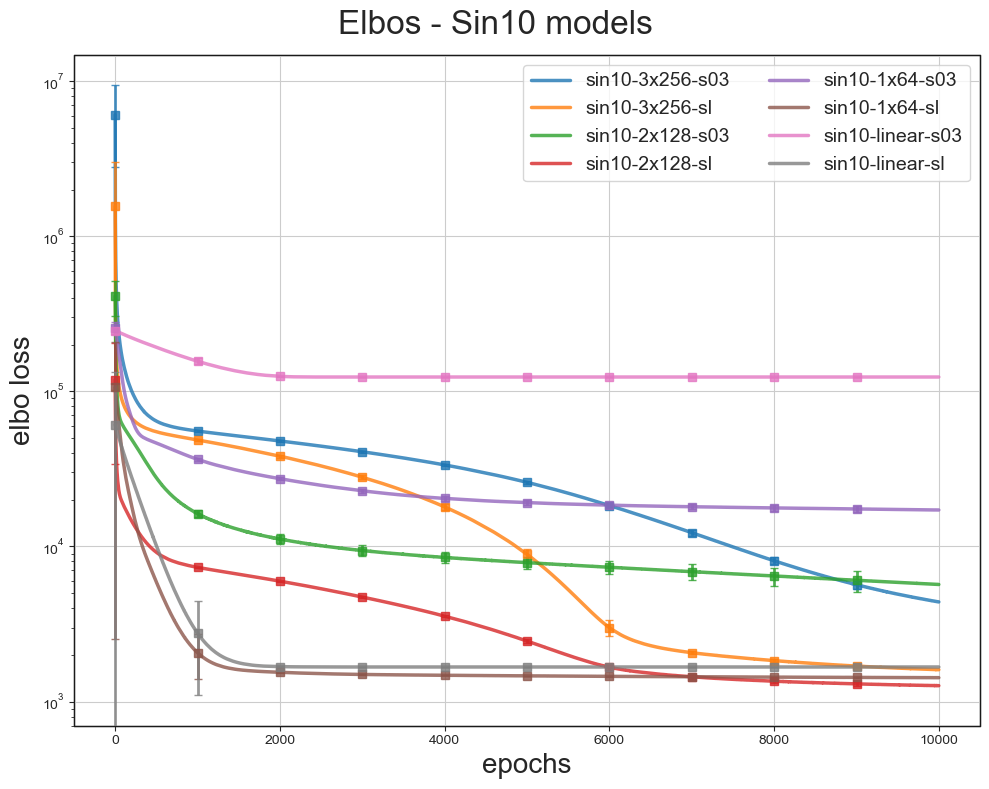

In [12]:

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(f"Elbos - {MODELS_TITLE} models", fontsize=24)
for i, p in enumerate(PROFILES):
    name = configs[p]["NAME"]
    elbos = [train_stats[name][i]["elbos"] for i in range(RERUNS)]
    means = np.mean(elbos, axis=0)
    stds = np.std(elbos, axis=0)
    ax.plot(means, label=name, color=colors[i], linewidth=2.5, alpha=0.8)

    err_range = list(range(0, len(means), 1000))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='s', color=colors[i], ms=6, alpha=0.8, fillstyle="full", capsize=3, linewidth=2.0)
ax.set_yscale("log", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend( fontsize=14, ncol=2, loc="upper right")
ax.set_xlabel("epochs", fontsize=20)
ax.set_ylabel("elbo loss", fontsize=20)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg")
plt.show()

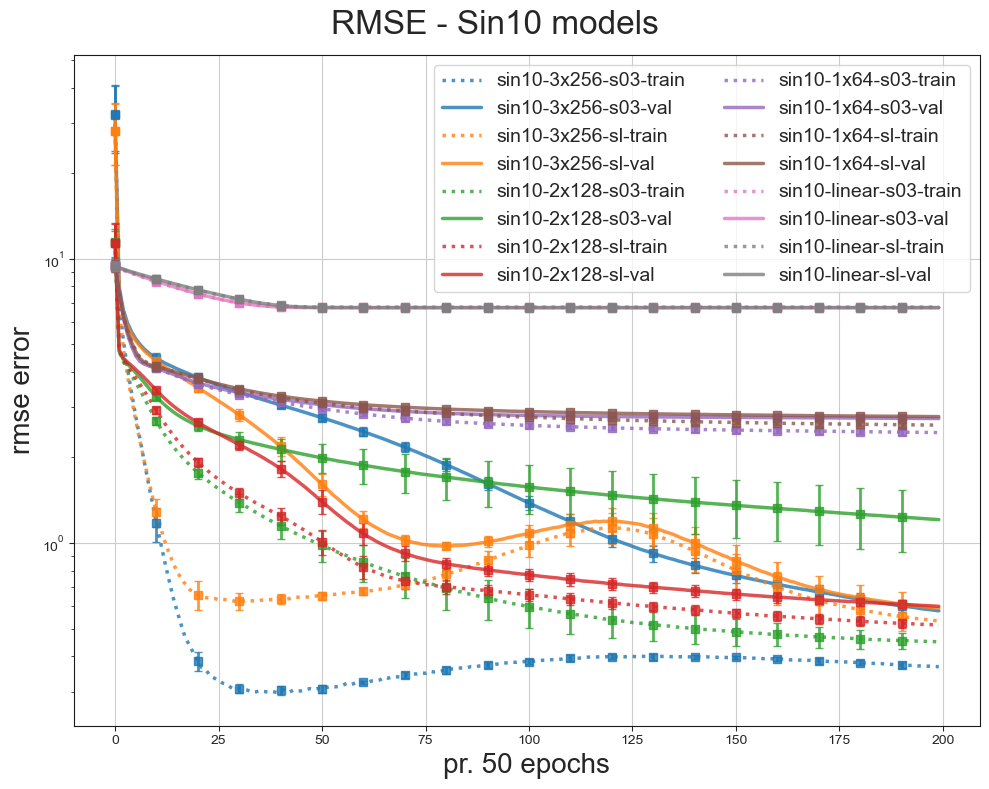

In [13]:
#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(f"RMSE - {MODELS_TITLE} models", fontsize=24)
for i, p in enumerate(PROFILES):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_rmse"] for i in range(RERUNS)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i], linewidth=2.5, alpha=0.8)
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.1, color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='s', color=colors[i], ms=6, alpha=0.8, fillstyle="full", capsize=3, linewidth=2.0)

    ve = [train_stats[name][i]["val_rmse"] for i in range(RERUNS)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i], linewidth=2.5, alpha=0.8)
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i], hatch='//')
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='s', color=colors[i], ms=6, alpha=0.8, fillstyle="full", capsize=3, linewidth=2.0)


    ax.set_yscale('log')
ax.legend( ncol=2, fontsize=14)
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("rmse error", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse.svg", format="svg")
plt.show()

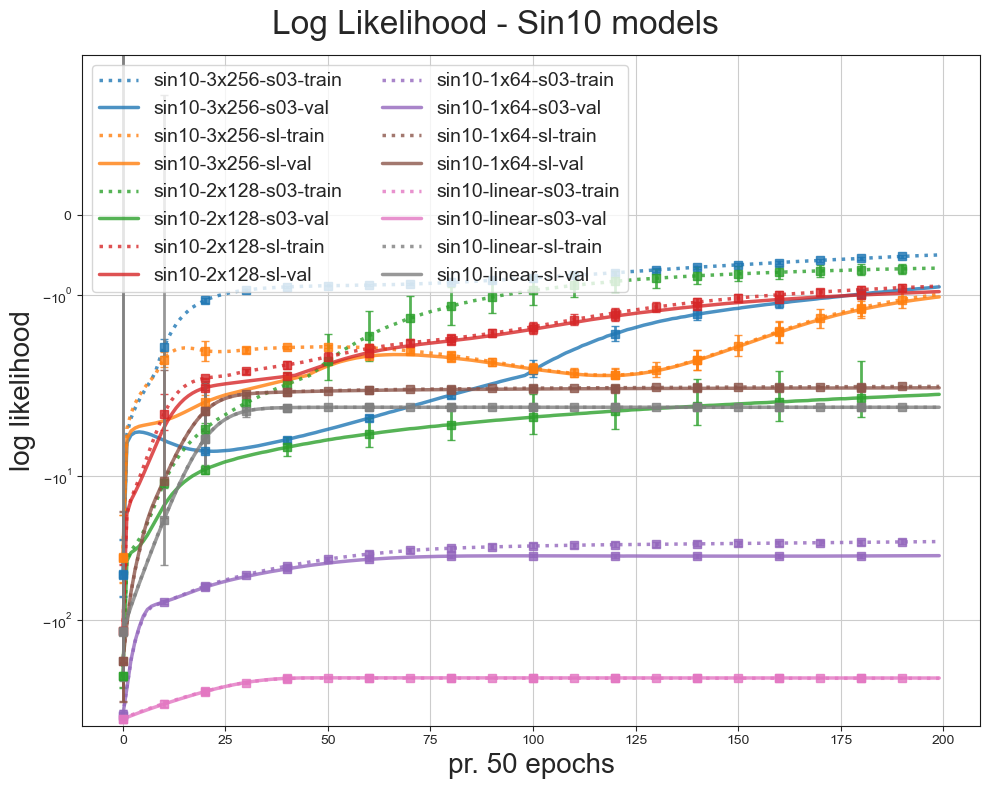

In [14]:
#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(f"Log Likelihood - {MODELS_TITLE} models", fontsize=24)
for i, p in enumerate(PROFILES):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_ll"] for i in range(RERUNS)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i], linewidth=2.5, alpha=0.8)
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='s', color=colors[i], ms=6, alpha=0.8, fillstyle="full", capsize=3, linewidth=2.0)

    ve = [train_stats[name][i]["val_ll"] for i in range(RERUNS)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i], linewidth=2.5, alpha=0.8)
    err_range = list(range(0, len(means), 20))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='s', color=colors[i], ms=6, alpha=0.8, fillstyle="full", capsize=3, linewidth=2.0)


plt.ylim(top=2)
ax.legend(ncol=2, fontsize=14)
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("log likelihood", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll.svg", format="svg")
plt.show()

In [15]:
run = 1

name1 = configs[PROFILES[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [16]:
data_samples

{'train_x': array([[ 0.10111914,  0.59942734,  0.8757908 , ..., -0.12627056,
         -1.2307777 , -1.7559822 ],
        [-0.82247317, -1.9920797 , -1.0743955 , ...,  0.09512219,
         -0.48497397,  0.48244318],
        [-0.31112495, -1.4061391 , -0.9059853 , ...,  0.5401983 ,
          0.22423759,  0.7231136 ],
        ...,
        [ 0.36448008, -0.08925682, -1.7424535 , ...,  0.77071244,
         -0.98118585, -1.2705014 ],
        [-1.1911093 , -1.3108561 ,  0.78218204, ...,  1.5261176 ,
         -1.8181038 , -1.9492189 ],
        [-0.07866658, -0.4814255 ,  1.5604229 , ...,  1.068271  ,
          1.7413484 , -0.03321254]], dtype=float32),
 'test_in_domain_x': array([[ 0.60711366,  0.54977775, -0.10806876, ..., -1.3402047 ,
          0.08701517,  1.595384  ],
        [ 0.2598087 ,  0.42272887, -0.50971186, ...,  1.1693558 ,
          0.2043035 ,  0.90268177],
        [-0.8823611 ,  0.27269322,  1.7310419 , ..., -0.81310624,
         -0.40559658, -0.5039171 ],
        ...,
        

In [17]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1][0]["train"].shape)

(1000, 10)
(1000, 1000)
(1000, 1000)


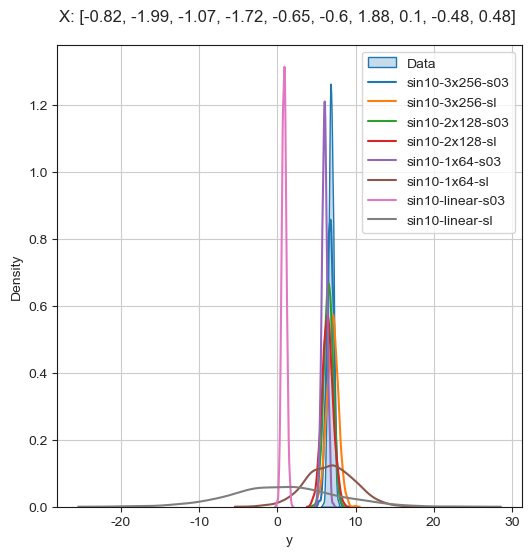

In [18]:
# Plot posterior samples
labels = [configs[p]["NAME"] for p in PROFILES]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p][run-1]["train"][:, 1] for p in PROFILES]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

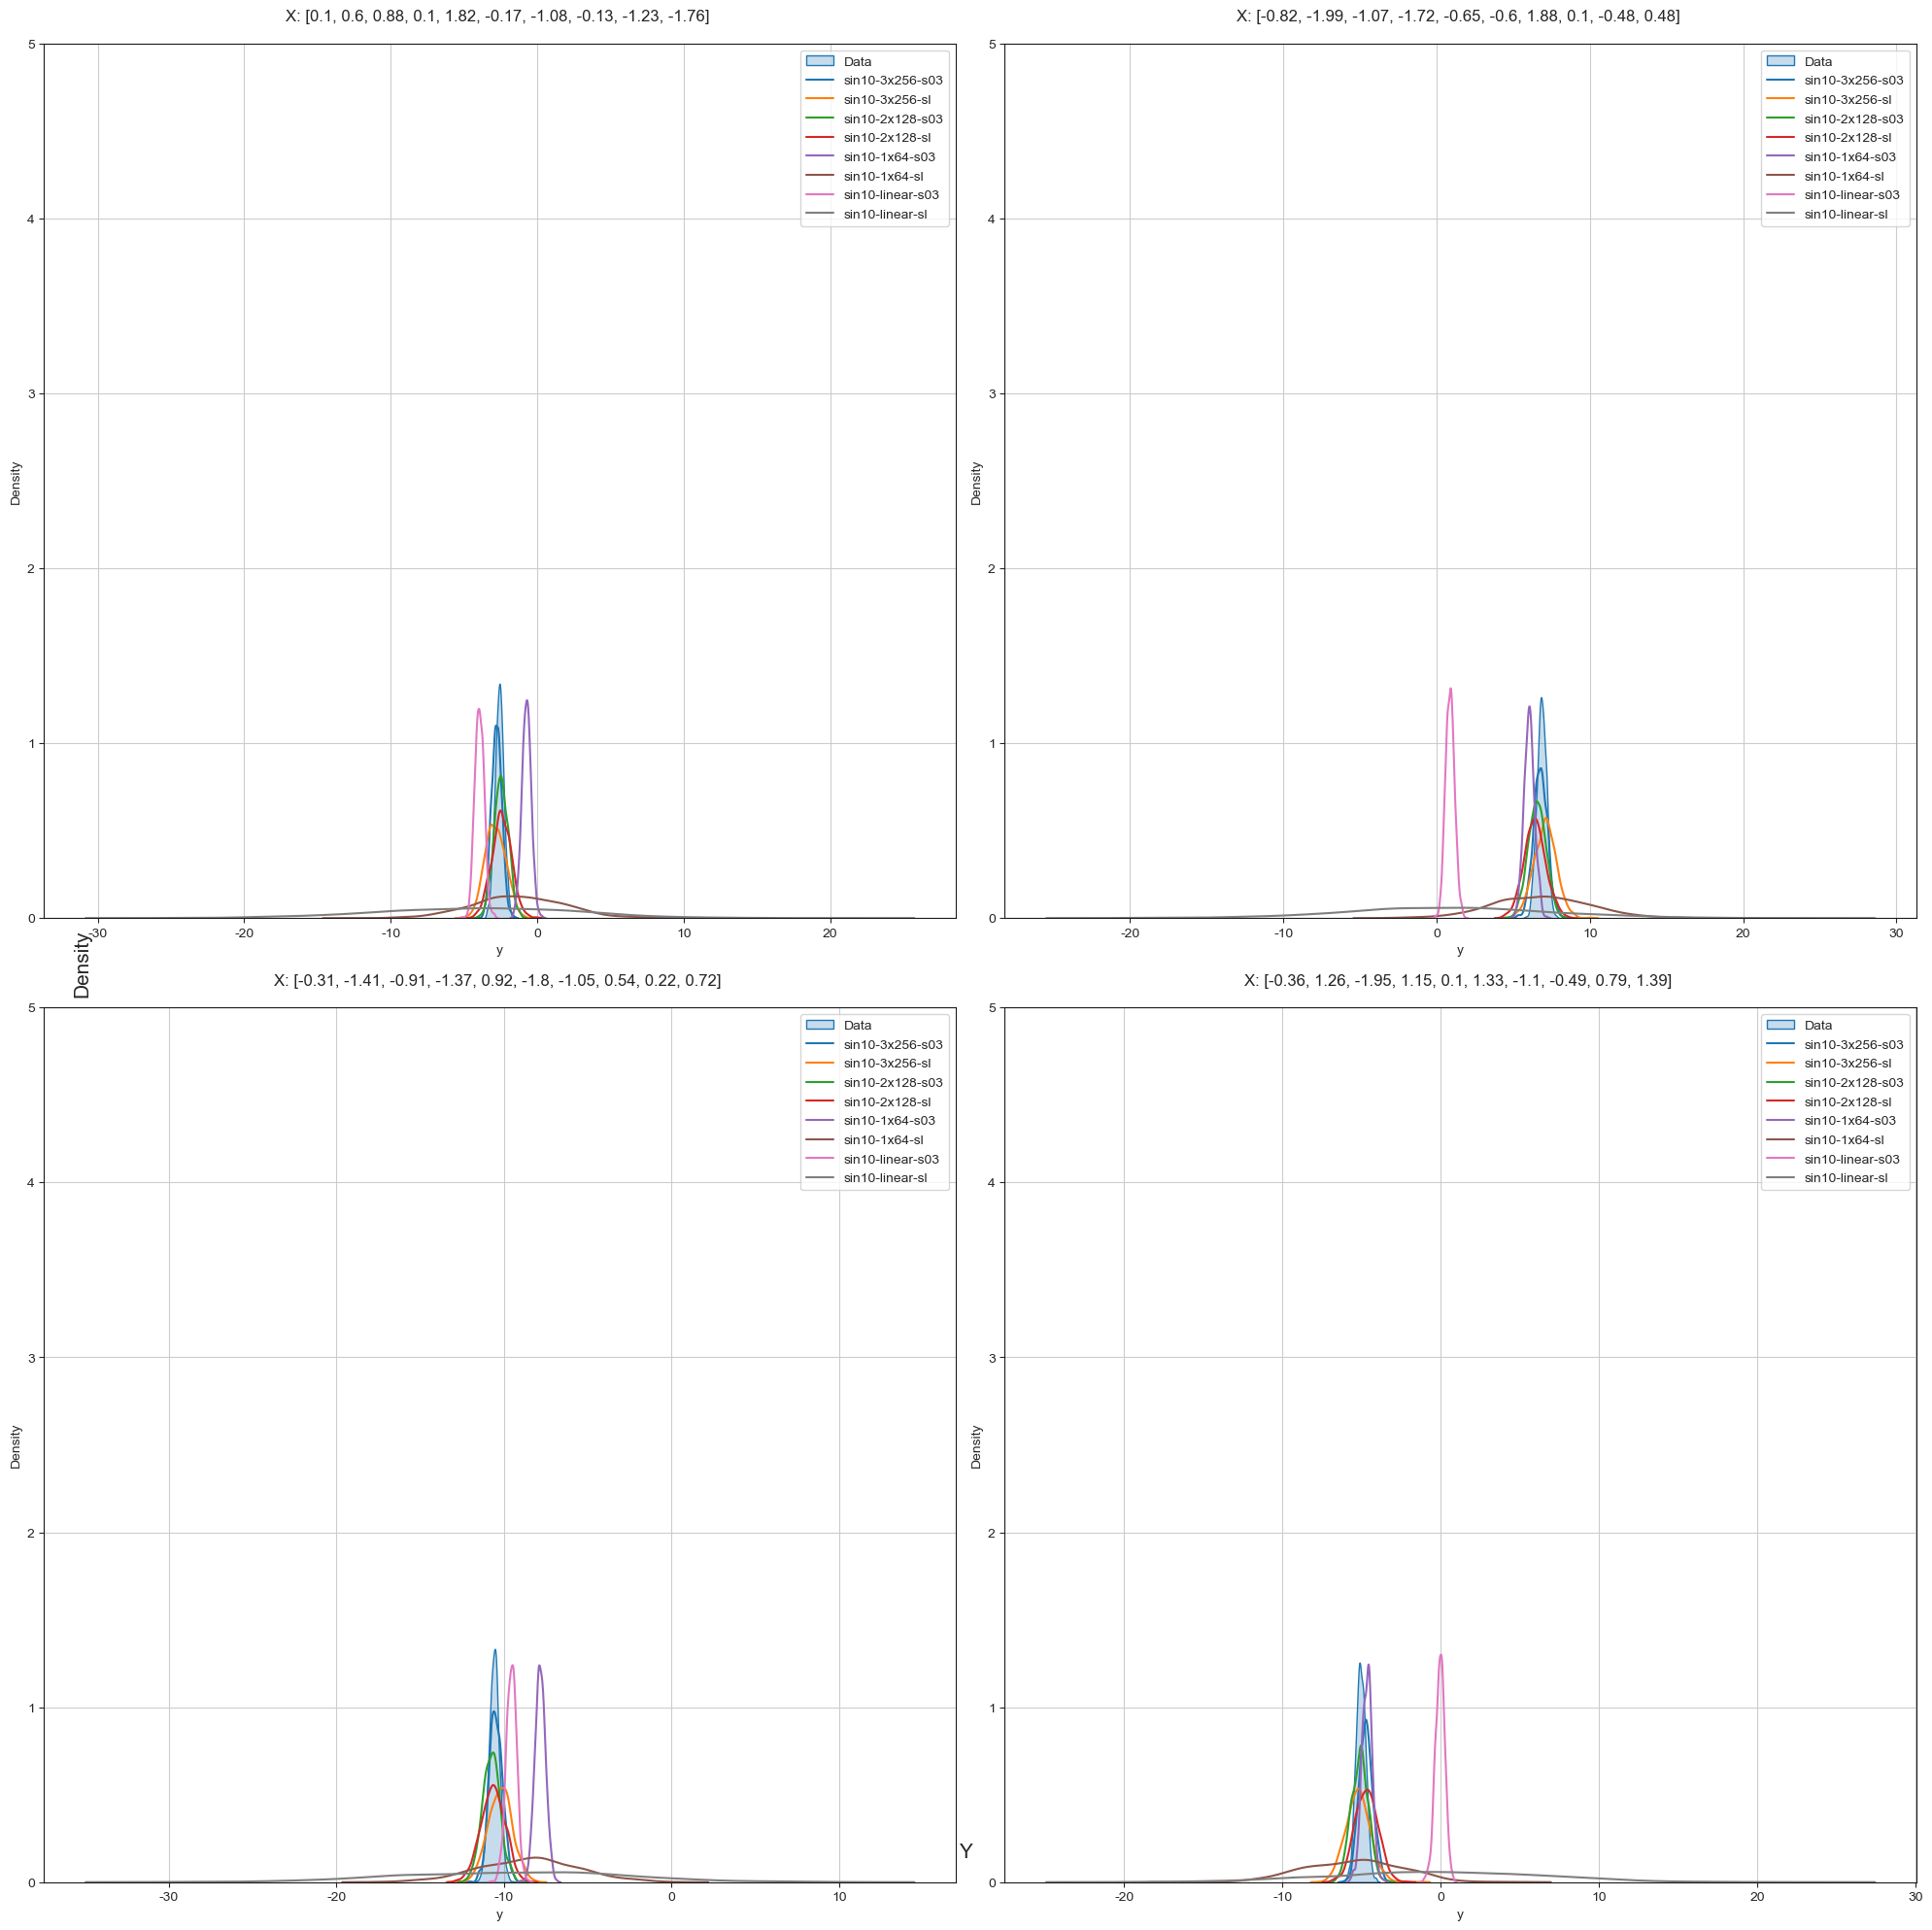

In [19]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in PROFILES]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["train"][:, i] for p in PROFILES]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.tight_layout()

plt.show()